<a href="https://colab.research.google.com/github/Aakash3101/Deep-Learning/blob/master/ML/Deep_learning/pytorch_tutorials/cifar10/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

## Loading the Dataset 

In [ ]:
# Training Data
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())

Extracting data/cifar-10-python.tar.gz to data/


In [ ]:
# Testing Data
test = CIFAR10(root='data/', train=False, download=False, transform=ToTensor())

In [ ]:
len(test)

10000

In [ ]:
len(dataset)

50000

In [ ]:
batch_size = 128

In [ ]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(40000, 10000)

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 3, 32, 32])


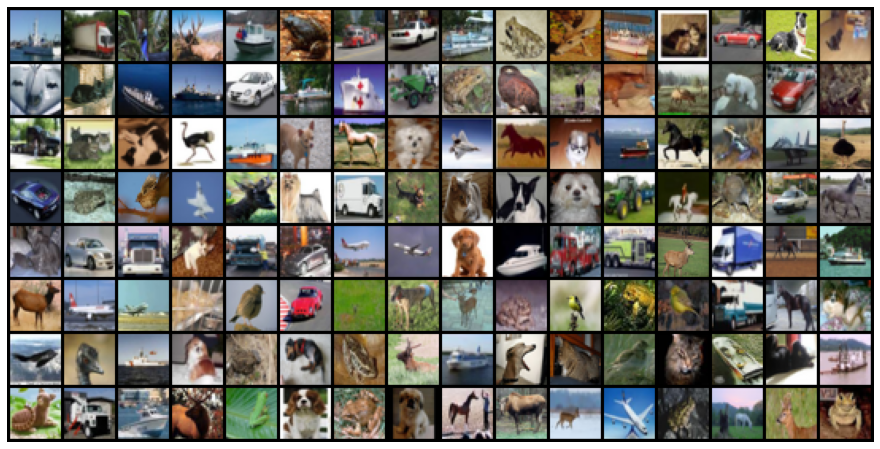

In [ ]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1,2,0)))
    break

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [4]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
torch.cuda.empty_cache()